In [ ]:
from google.colab import drive
drive.mount('/content/drive')


!pip install lightfm
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import glob
import tqdm
import json
import optuna

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/My Drive/recsys/hw1/test.csv')
test_df['test'] = True
test_df['time'] = 100
train_df = pd.read_csv('/content/drive/My Drive/recsys/hw1/train.csv')
train_df['test'] = False

## Берем позитивные примеры

In [ ]:
# прежде чем что-то обучать, нужно выбрать позитивные примеры, на которых будем строить LightFM
# здесь можно поменять порог
data  = pd.concat([train_df, test_df])

positives = data[data["time"] >= 0.0].copy()
positives.drop_duplicates(["user", "track"], inplace=True)
positives.head()

,user,track,time,test
0,ee8621197232afef4ae573079d64480ba7640c9eb91a7e...,41378,1.0,False
1,9b19f9ab816598a0809e4afd5d60800f2dbef9cbb9b03a...,44158,0.0,False
2,be3d629f02589a093027c0b917aa7668f22b2f89e83328...,1263,0.8,False
3,3d810b358ef3f88619945df4182acda92a24e99c8b28e8...,3781,0.0,False
4,2261b761b06d13e4ca4118d58d91eb7312ae864b2916d7...,32711,0.0,False


## Собираем каталог пользователей и треков для трейна

In [ ]:
# собираем каталог пользователей и треков, для которых и на которых хотим делать рекомендации (потом поменяем число)
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

## Всякие полезные функции

In [ ]:
def get_test_csv(test_data, predictions):
    test_data['score'] = predictions
    test_data.to_csv('results.csv')


## Train LightFM

In [ ]:
# почему у нас для теста и трейна одинаковые пользователи и треки и можно ли это как-то обойти?
# Если бы мы включили в Train идентификаторы пользователей с холодным запуском, они бы не взаимодействовали.
# Если мы включим их в тест, а не в обучение, то LightFM выдаст ошибку, когда увидит новый идентификатор,
# поскольку у него не будет соответствующей функции идентификации для нового элемента/пользователя.
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(1671368, 38790)

In [ ]:
# каждая строчка матрицы пользователя будет эмбеддингом пользователя
# каждая строчка матрицы трека будет эмбеддингом трека
dataset = ld.Dataset()
dataset.fit(users, tracks)
# в качестве item_features и user_features можно добавить всякую хуйню из tracks.json

In [ ]:
# строим матрицы интеракций (матрица взаимодействий пользователей и треков)
train_interactions, weights = dataset.build_interactions(train_data[["user", "track","time"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [ ]:
def fit_model(
        epochs=1,
        at=10,  # то самое K, с помощью которого мы будем измерять precisions@k
        loss="warp",  # функция потерь
        no_components=30,  # размерность эмбеддингов
        learning_rate=0.01,
        max_sampled=10,
        # количество негативных айтемов, которые мы сэмплируем до тех пор пока не найдем первые непрвтльные отранжированную пару
        # два параметра регуляризации
        user_alpha=0.0,
        item_alpha=0.0,
        # всякие технические параметры
        threads=30,
        verbose=False,
        patience=3,
        epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []

    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, sample_weight=weights, num_threads=threads)
        # считаем метрику
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at,
                                         num_threads=threads)

        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")

        precisions_at.append(np.mean(precision_at))

        if epoch > patience and all(
                [precisions_at[-j] - precisions_at[-patience - 1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            # break

    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")

    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp"])
    no_components = trial.suggest_categorical("no_components", [30, 40, 60, 70, 80])
    learning_rate = trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1])
    max_sampled = trial.suggest_categorical("max_sampled", [1000, 10000, 50000, 100000, 200000])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.1, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.1, 0.0001])

    model, precisions_at = fit_model(
        epochs=20,
        at=10,
        loss=loss,
        no_components=no_components,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    return precisions_at[-1]

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
best_params = study.best_params
best_params

In [ ]:
# нужно, чтобы посмотреть, насколько важен тот или иной гиперпараметр
optuna.importance.get_param_importances(study)

{'item_alpha': 0.2781017856877268,
 'no_components': 0.2692654486151563,
 'max_sampled': 0.18776952199638816,
 'learning_rate': 0.18275583764742334,
 'user_alpha': 0.08210740605330549,
 'loss': 0.0}

In [ ]:
# model, precisions_at = fit_model(
#     epochs=300,
#     at=10,
#     loss=best_params["loss"],
#     no_components=best_params["no_components"],
#     learning_rate=best_params["learning_rate"],
#     max_sampled=best_params["max_sampled"],
#     user_alpha=best_params["user_alpha"],
#     item_alpha=best_params["item_alpha"],
#     verbose=True,
# )

model, precisions_at = fit_model(
    epochs=300,
    at=10,
    loss='warp',
    no_components=40,
    learning_rate=0.1,
    max_sampled=100000,
    user_alpha=0.0,
    item_alpha=0.0,
    verbose=True,
)

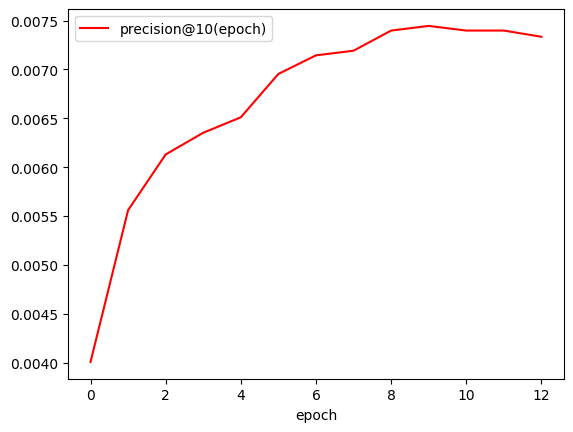

In [ ]:
# TODO 1.4: Plot learning curve precision@k(epoch)
figure, ax = pl.subplots()

ax.plot(list(range(len(precisions_at))), precisions_at, "r", label="precision@10(epoch)")

ax.set_xlabel("epoch")
ax.legend()

pass

## Обучение модели на всё датасете

In [ ]:
# Обучение модели LightFM
model = lightfm.LightFM(
    loss='warp',
    no_components=40,
    learning_rate=0.1,
    max_sampled=100000,
    user_alpha=0.0,
    item_alpha=0.0,
)
model.fit(train_interactions, sample_weight=weights, epochs=20, num_threads=30, verbose=True)

Epoch: 100%|██████████| 20/20 [1:21:31<00:00, 244.60s/it]


In [ ]:
from lightfm.evaluation import auc_score

precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=10, num_threads=30)
train_auc = auc_score(model, train_interactions, num_threads=30).mean()
test_auc = auc_score(model, test_interactions, train_interactions=train_interactions, num_threads=30).mean()

print(f"Precision at 10  = {precision_at}")
print(f"ROCS AUC at train = {train_auc}")
print(f"ROCS AUC at test = {test_auc}")

In [ ]:
scores = model.predict(test_data[["user"]], test_data[ "track"])
get_test_csv(test_data, scores)
print("Результаты предсказаний модели на тестовом наборе данных:")
print(scores)